In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import RobertaModel, AdamW
from transformers import RobertaTokenizer
import torch.optim as optim
from transformers import RobertaTokenizer
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import nltk
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from tqdm import tqdm
from nltk.tokenize import sent_tokenize
import numpy as np
import os

2023-10-17 19:08:49.692933: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
class BertAtt(nn.Module):
    def __init__(self, d_e, h):
        super(BertAtt, self).__init__()
        self.num_heads = h
        self.d_e = d_e
        self.head_dim = d_e // h
        
        self.q = nn.Linear(d_e, d_e)
        self.k = nn.Linear(d_e, d_e)
        self.v = nn.Linear(d_e, d_e)
        
        self.o = nn.Linear(d_e, d_e)
        self.layer_norm = nn.LayerNorm(d_e)
        
        self.dropout = nn.Dropout(dropout_prob)
        
    def forward(self, x):
        Q = self.q(x)
        K = self.k(x)
        V = self.v(x)
        
        Q = Q.view(Q.size(0), -1, self.num_heads, self.head_dim).permute(0, 2, 1, 3)
        K = K.view(K.size(0), -1, self.num_heads, self.head_dim).permute(0, 2, 1, 3)
        V = V.view(V.size(0), -1, self.num_heads, self.head_dim).permute(0, 2, 1, 3)
        
        
        attention_scores = torch.matmul(Q, K.permute(0, 1, 3, 2)) / (self.d_e**0.5)
        attention_probs = F.softmax(attention_scores, dim=-1)
        context = torch.matmul(attention_probs, V)
        
        context = context.permute(0, 2, 1, 3).contiguous()
        context = context.view(context.size(0), -1, self.num_heads*self.head_dim)
        context = self.dropout(context)
        context = self.o(context)
        
        return self.layer_norm(x + context)

class HBN(nn.Module):
    def __init__(self, d_e, h, m, n, y, dropout_prob=0.01, max_sentences=114):
        super(HBN, self).__init__()
        
        # Token-level Roberta encoder
        self.roberta = RobertaModel.from_pretrained("roberta-base")
        
        # Freeze Roberta weights
        for param in self.roberta.parameters():
            param.requires_grad = False
        
        # Sentence-level BERT Encoder
        self.bertatt = BertAtt(d_e, h)
        
        self.ff = nn.Sequential(
            nn.Linear(d_e, n*d_e),
            nn.ReLU(),
            nn.Linear(n*d_e, d_e)
        )
        self.layer_norm = nn.LayerNorm(d_e)
        
        self.multiple_bert_layers = nn.ModuleList([BertAtt(d_e, h) for _ in range(m)])
        
        self.transformation = nn.Linear(d_e, d_e)
        
        self.dropout = nn.Dropout(dropout_prob)
        
        # Prediction Layer
        self.predict = nn.Linear(d_e, y)
        
    def forward(self, input_ids, attention_mask):
#         print(input_ids.shape)
        # Token-level Roberta encoding
        roberta_outputs = self.roberta(input_ids=input_ids, attention_mask=attention_mask)[0]  # [batch_size, seq_length, hidden_size]
        
        # Average pooling to get sentence embeddings
        D = torch.mean(roberta_outputs, dim=1)  # [batch_size, hidden_size]
        
        out = self.bertatt(D)
        out = self.layer_norm(out + F.relu(self.ff(out)))
        
        Z = out
        for layer in self.multiple_bert_layers:
            Z = layer(Z)
        
        S = torch.tanh(torch.mean(Z, dim=1).mm(self.transformation.weight))
        S = self.dropout(S)
        scores = S.mm(self.predict.weight.t())
        
        return scores


In [3]:
# Parameters
d_e = 768  # Assuming you are using 'roberta-base'
h = 1     # Number of attention heads
m = 4      # Number of identical BERT layers
n = 4      # Scaling factor for feed-forward network
y = 2      # Number of classes, set this to your actual number
dropout_prob = 0.01 #dropout probability
samples = [50, 100, 150, 200]
num_epochs = 50
max_length = 128

In [4]:
import os
import pandas as pd
from nltk.tokenize import sent_tokenize

folder1_path = 'sample-text/sample-text/politics/'
folder2_path = 'sample-text/sample-text/business/'

# Fetch file names from both folders
folder1_files = [f for f in os.listdir(folder1_path) if f.endswith('.txt')]
folder2_files = [f for f in os.listdir(folder2_path) if f.endswith('.txt')]

combined_data = []
num_sent=[]

# Read and label files from folder1 and count sentences
for file in folder1_files:
    with open(os.path.join(folder1_path, file), 'r') as f:
        content = f.read()
        num_sentences = len(sent_tokenize(content))
        combined_data.append((content, 0))
        num_sent.append(num_sentences)

# Read and label files from folder2 and count sentences
for file in folder2_files:
    with open(os.path.join(folder2_path, file), 'r') as f:
        content = f.read()
        num_sentences = len(sent_tokenize(content))
        combined_data.append((content, 1))
        num_sent.append(num_sentences)

# Convert combined_data to DataFrame
df = pd.DataFrame(combined_data, columns=['content', 'label'])

# Shuffle the DataFrame
data = df.sample(frac=1).reset_index(drop=True)

# Display the shuffled DataFrame
print(data)

# Find out the maximum number of sentences across all files
max_sentences = max(num_sent)
print(f"\nMaximum number of sentences across all files: {max_sentences}")


                                               content  label
0    Oil companies get Russian setback\n\nInternati...      1
1    Mexican in US send $16bn home\n\nMexican labou...      1
2    Japanese mogul arrested for fraud\n\nOne of Ja...      1
3    House prices show slight increase\n\nPrices of...      1
4    US bank in $515m SEC settlement\n\nFive Bank o...      1
..                                                 ...    ...
593  China continues breakneck growth\n\nChina's ec...      1
594  Clarke to unveil immigration plan\n\nNew contr...      0
595  Blair congratulates Bush on win\n\nTony Blair ...      0
596  China had role in Yukos split-up\n\nChina lent...      1
597  Macy's owner buys rival for $11bn\n\nUS retail...      1

[598 rows x 2 columns]

Maximum number of sentences across all files: 248


In [5]:
# len(test_indices),len(train_indices),len(val_indices)

In [6]:
# len(reviews_sentences)

In [7]:
auc_results = {}
for num_train_samples in samples:    
    # 2. Split data into train, validation, and test samples
    num_train_samples = num_train_samples
    num_val_samples = int(0.6 * num_train_samples)
    train_data = data.iloc[:num_train_samples]
    val_data = data.iloc[num_train_samples:num_train_samples+num_val_samples]
    test_data = data.iloc[num_train_samples+num_val_samples:]

    # 3. Preprocess and Flatten
    def preprocess_and_flatten(dataframe):
        reviews = dataframe['content'].tolist()
        labels = dataframe['label'].tolist()
        reviews = [review.lower() for review in reviews]
        reviews_sentences = [sent_tokenize(review) for review in reviews]
        flattened_reviews = [sentence for review in reviews_sentences for sentence in review]
        flattened_labels = [label for review, label in zip(reviews_sentences, labels) for sentence in review]
        return flattened_reviews, flattened_labels

    train_reviews, train_labels = preprocess_and_flatten(train_data)
    val_reviews, val_labels = preprocess_and_flatten(val_data)
    test_reviews, test_labels = preprocess_and_flatten(test_data)

    # 4. Tokenization
    tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
    train_tokens = tokenizer(train_reviews, padding=True, truncation=True, return_tensors="pt", max_length=max_length)
    val_tokens = tokenizer(val_reviews, padding=True, truncation=True, return_tensors="pt", max_length=max_length)
    test_tokens = tokenizer(test_reviews, padding=True, truncation=True, return_tensors="pt", max_length=max_length)

    # 5. Create DataLoader
    train_batch_size = 4
    val_batch_size = 4
    test_batch_size = 4

    train_dataset = TensorDataset(train_tokens['input_ids'], train_tokens['attention_mask'], torch.tensor(train_labels))
    val_dataset = TensorDataset(val_tokens['input_ids'], val_tokens['attention_mask'], torch.tensor(val_labels))
    test_dataset = TensorDataset(test_tokens['input_ids'], test_tokens['attention_mask'], torch.tensor(test_labels))

    train_loader = DataLoader(train_dataset, shuffle=True, batch_size=train_batch_size)
    val_loader = DataLoader(val_dataset, shuffle=False, batch_size=val_batch_size)
    test_loader = DataLoader(test_dataset, shuffle=False, batch_size=test_batch_size)

#     # Uncomment to test: iterating over the DataLoader
#     for batch in train_loader:
#         input_ids, attention_mask, labels = batch
#         print(f'num={num_train_samples }',input_ids.shape, attention_mask.shape, labels.shape)
#     len(train_loader.dataset),len(val_loader.dataset),len(test_loader.dataset)

    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Initialize the model
    model = HBN(d_e, h, m, n, y, dropout_prob).to(device)

    # Loss and Optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=2e-5, eps=1e-8)
    
    def train(model, dataloader, optimizer, criterion, device, epoch):
        model.train()
        total_loss = 0
        for batch in tqdm(dataloader, desc=f"Epoch {epoch + 1}/{num_epochs}"):
            input_ids, attention_mask, labels = batch

            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)
            loss.backward()
    #         torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            total_loss += loss.item()

        return total_loss / len(dataloader)

    def evaluate(model, dataloader, criterion, device):
        model.eval()
        total_loss = 0
        correct_predictions = 0
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for batch in tqdm(dataloader):
                input_ids, attention_mask, labels = batch

                input_ids = input_ids.to(device)
                attention_mask = attention_mask.to(device)
                labels = labels.to(device)

                outputs = model(input_ids, attention_mask)
                loss = criterion(outputs, labels)
                total_loss += loss.item()

                _, preds = torch.max(outputs, dim=1)
                correct_predictions += torch.sum(preds == labels)

                # For AUC
                # Assuming binary classification; you need to get the probabilities for the positive class
                probs = torch.nn.functional.softmax(outputs, dim=1)[:, 1]
                all_preds.extend(probs.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        accuracy = correct_predictions.double() / len(dataloader.dataset)
        auc = roc_auc_score(all_labels, all_preds)
        return total_loss / len(dataloader), accuracy, auc

    # Actual Training Loop
    num_epochs = 50
    train_loss_epoch = []
    test_loss_epoch = []
    auc = []
    for epoch in range(num_epochs):
        train_loss = train(model, train_loader, optimizer, criterion, device, epoch)
        print(f"Train Loss: {train_loss:.4f}")
        test_loss, test_accuracy, test_auc = evaluate(model, val_loader, criterion, device)
        print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}, Test AUC: {test_auc:.4f}")
        train_loss_epoch.append(train_loss)
        test_loss_epoch.append(test_loss)
        auc.append(test_auc)
    auc_results[num_train_samples] = auc

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1/50: 100%|██████████| 198/198 [00:46<00:00,  4.22it/s]


Train Loss: 0.6242


100%|██████████| 141/141 [00:22<00:00,  6.34it/s]


Test Loss: 0.5721, Test Accuracy: 0.6791, Test AUC: 0.9309


Epoch 2/50: 100%|██████████| 198/198 [00:45<00:00,  4.31it/s]


Train Loss: 0.3477


100%|██████████| 141/141 [00:22<00:00,  6.36it/s]


Test Loss: 0.4674, Test Accuracy: 0.8085, Test AUC: 0.9370


Epoch 3/50: 100%|██████████| 198/198 [00:45<00:00,  4.32it/s]


Train Loss: 0.2470


100%|██████████| 141/141 [00:21<00:00,  6.45it/s]


Test Loss: 0.3556, Test Accuracy: 0.8528, Test AUC: 0.9324


Epoch 4/50: 100%|██████████| 198/198 [00:45<00:00,  4.37it/s]


Train Loss: 0.2052


100%|██████████| 141/141 [00:21<00:00,  6.42it/s]


Test Loss: 0.5019, Test Accuracy: 0.8333, Test AUC: 0.9292


Epoch 5/50: 100%|██████████| 198/198 [00:46<00:00,  4.25it/s]


Train Loss: 0.1777


100%|██████████| 141/141 [00:21<00:00,  6.42it/s]


Test Loss: 0.4029, Test Accuracy: 0.8511, Test AUC: 0.9237


Epoch 6/50: 100%|██████████| 198/198 [00:45<00:00,  4.34it/s]


Train Loss: 0.1659


100%|██████████| 141/141 [00:21<00:00,  6.47it/s]


Test Loss: 0.4222, Test Accuracy: 0.8546, Test AUC: 0.9226


Epoch 7/50: 100%|██████████| 198/198 [00:45<00:00,  4.37it/s]


Train Loss: 0.1551


100%|██████████| 141/141 [00:21<00:00,  6.48it/s]


Test Loss: 0.3967, Test Accuracy: 0.8475, Test AUC: 0.9246


Epoch 8/50: 100%|██████████| 198/198 [00:45<00:00,  4.36it/s]


Train Loss: 0.1745


100%|██████████| 141/141 [00:21<00:00,  6.47it/s]


Test Loss: 0.4197, Test Accuracy: 0.8493, Test AUC: 0.9265


Epoch 9/50: 100%|██████████| 198/198 [00:45<00:00,  4.36it/s]


Train Loss: 0.1363


100%|██████████| 141/141 [00:21<00:00,  6.45it/s]


Test Loss: 0.4262, Test Accuracy: 0.8422, Test AUC: 0.9224


Epoch 10/50: 100%|██████████| 198/198 [00:45<00:00,  4.31it/s]


Train Loss: 0.1272


100%|██████████| 141/141 [00:23<00:00,  6.10it/s]


Test Loss: 0.4318, Test Accuracy: 0.8404, Test AUC: 0.9175


Epoch 11/50: 100%|██████████| 198/198 [00:46<00:00,  4.30it/s]


Train Loss: 0.1426


100%|██████████| 141/141 [00:21<00:00,  6.43it/s]


Test Loss: 0.4976, Test Accuracy: 0.8050, Test AUC: 0.9209


Epoch 12/50: 100%|██████████| 198/198 [00:44<00:00,  4.43it/s]


Train Loss: 0.1315


100%|██████████| 141/141 [00:21<00:00,  6.52it/s]


Test Loss: 0.4436, Test Accuracy: 0.8227, Test AUC: 0.9128


Epoch 13/50: 100%|██████████| 198/198 [00:45<00:00,  4.38it/s]


Train Loss: 0.1098


100%|██████████| 141/141 [00:22<00:00,  6.28it/s]


Test Loss: 0.6410, Test Accuracy: 0.8245, Test AUC: 0.9135


Epoch 14/50: 100%|██████████| 198/198 [00:45<00:00,  4.38it/s]


Train Loss: 0.1553


100%|██████████| 141/141 [00:21<00:00,  6.49it/s]


Test Loss: 0.6817, Test Accuracy: 0.8191, Test AUC: 0.9148


Epoch 15/50: 100%|██████████| 198/198 [00:44<00:00,  4.42it/s]


Train Loss: 0.1124


100%|██████████| 141/141 [00:22<00:00,  6.39it/s]


Test Loss: 0.7314, Test Accuracy: 0.8209, Test AUC: 0.9162


Epoch 16/50: 100%|██████████| 198/198 [00:45<00:00,  4.39it/s]


Train Loss: 0.1096


100%|██████████| 141/141 [00:22<00:00,  6.34it/s]


Test Loss: 0.4758, Test Accuracy: 0.8404, Test AUC: 0.9098


Epoch 17/50: 100%|██████████| 198/198 [00:44<00:00,  4.43it/s]


Train Loss: 0.0798


100%|██████████| 141/141 [00:21<00:00,  6.42it/s]


Test Loss: 0.7209, Test Accuracy: 0.8138, Test AUC: 0.9098


Epoch 18/50: 100%|██████████| 198/198 [00:44<00:00,  4.43it/s]


Train Loss: 0.1025


100%|██████████| 141/141 [00:21<00:00,  6.58it/s]


Test Loss: 0.5869, Test Accuracy: 0.8298, Test AUC: 0.9137


Epoch 19/50: 100%|██████████| 198/198 [00:45<00:00,  4.33it/s]


Train Loss: 0.0987


100%|██████████| 141/141 [00:22<00:00,  6.32it/s]


Test Loss: 0.5618, Test Accuracy: 0.8351, Test AUC: 0.9105


Epoch 20/50: 100%|██████████| 198/198 [00:45<00:00,  4.34it/s]


Train Loss: 0.1172


100%|██████████| 141/141 [00:22<00:00,  6.38it/s]


Test Loss: 0.4857, Test Accuracy: 0.8262, Test AUC: 0.9082


Epoch 21/50: 100%|██████████| 198/198 [00:45<00:00,  4.33it/s]


Train Loss: 0.0889


100%|██████████| 141/141 [00:22<00:00,  6.35it/s]


Test Loss: 0.6376, Test Accuracy: 0.8209, Test AUC: 0.9093


Epoch 22/50: 100%|██████████| 198/198 [00:45<00:00,  4.32it/s]


Train Loss: 0.0995


100%|██████████| 141/141 [00:22<00:00,  6.36it/s]


Test Loss: 0.5661, Test Accuracy: 0.8245, Test AUC: 0.9057


Epoch 23/50: 100%|██████████| 198/198 [00:46<00:00,  4.25it/s]


Train Loss: 0.1238


100%|██████████| 141/141 [00:21<00:00,  6.45it/s]


Test Loss: 0.5420, Test Accuracy: 0.8369, Test AUC: 0.9091


Epoch 24/50: 100%|██████████| 198/198 [00:45<00:00,  4.37it/s]


Train Loss: 0.0839


100%|██████████| 141/141 [00:21<00:00,  6.43it/s]


Test Loss: 0.6320, Test Accuracy: 0.8191, Test AUC: 0.9075


Epoch 25/50: 100%|██████████| 198/198 [00:45<00:00,  4.38it/s]


Train Loss: 0.0799


100%|██████████| 141/141 [00:21<00:00,  6.46it/s]


Test Loss: 0.7093, Test Accuracy: 0.8138, Test AUC: 0.9055


Epoch 26/50: 100%|██████████| 198/198 [00:44<00:00,  4.42it/s]


Train Loss: 0.0749


100%|██████████| 141/141 [00:22<00:00,  6.39it/s]


Test Loss: 0.6158, Test Accuracy: 0.8280, Test AUC: 0.9077


Epoch 27/50: 100%|██████████| 198/198 [00:45<00:00,  4.35it/s]


Train Loss: 0.1001


100%|██████████| 141/141 [00:22<00:00,  6.40it/s]


Test Loss: 0.4946, Test Accuracy: 0.8422, Test AUC: 0.9083


Epoch 28/50: 100%|██████████| 198/198 [00:45<00:00,  4.35it/s]


Train Loss: 0.0794


100%|██████████| 141/141 [00:22<00:00,  6.40it/s]


Test Loss: 0.6345, Test Accuracy: 0.8280, Test AUC: 0.9039


Epoch 29/50: 100%|██████████| 198/198 [00:45<00:00,  4.40it/s]


Train Loss: 0.0826


100%|██████████| 141/141 [00:21<00:00,  6.67it/s]


Test Loss: 0.6033, Test Accuracy: 0.8404, Test AUC: 0.9060


Epoch 30/50: 100%|██████████| 198/198 [00:44<00:00,  4.48it/s]


Train Loss: 0.0750


100%|██████████| 141/141 [00:22<00:00,  6.38it/s]


Test Loss: 0.6443, Test Accuracy: 0.8209, Test AUC: 0.9059


Epoch 31/50: 100%|██████████| 198/198 [00:45<00:00,  4.38it/s]


Train Loss: 0.0808


100%|██████████| 141/141 [00:22<00:00,  6.34it/s]


Test Loss: 0.5896, Test Accuracy: 0.8333, Test AUC: 0.9057


Epoch 32/50: 100%|██████████| 198/198 [00:45<00:00,  4.37it/s]


Train Loss: 0.0837


100%|██████████| 141/141 [00:21<00:00,  6.50it/s]


Test Loss: 0.6416, Test Accuracy: 0.8280, Test AUC: 0.9029


Epoch 33/50: 100%|██████████| 198/198 [00:45<00:00,  4.39it/s]


Train Loss: 0.0557


100%|██████████| 141/141 [00:21<00:00,  6.54it/s]


Test Loss: 0.9202, Test Accuracy: 0.7961, Test AUC: 0.9094


Epoch 34/50: 100%|██████████| 198/198 [00:44<00:00,  4.42it/s]


Train Loss: 0.0782


100%|██████████| 141/141 [00:21<00:00,  6.54it/s]


Test Loss: 0.6103, Test Accuracy: 0.8369, Test AUC: 0.9101


Epoch 35/50: 100%|██████████| 198/198 [00:44<00:00,  4.42it/s]


Train Loss: 0.0600


100%|██████████| 141/141 [00:21<00:00,  6.50it/s]


Test Loss: 0.6381, Test Accuracy: 0.8404, Test AUC: 0.9100


Epoch 36/50: 100%|██████████| 198/198 [00:44<00:00,  4.41it/s]


Train Loss: 0.0687


100%|██████████| 141/141 [00:21<00:00,  6.50it/s]


Test Loss: 0.6662, Test Accuracy: 0.8351, Test AUC: 0.9069


Epoch 37/50: 100%|██████████| 198/198 [00:44<00:00,  4.43it/s]


Train Loss: 0.0572


100%|██████████| 141/141 [00:21<00:00,  6.53it/s]


Test Loss: 0.6867, Test Accuracy: 0.8316, Test AUC: 0.9067


Epoch 38/50: 100%|██████████| 198/198 [00:44<00:00,  4.44it/s]


Train Loss: 0.0666


100%|██████████| 141/141 [00:21<00:00,  6.51it/s]


Test Loss: 0.5784, Test Accuracy: 0.8298, Test AUC: 0.9061


Epoch 39/50: 100%|██████████| 198/198 [00:44<00:00,  4.44it/s]


Train Loss: 0.0691


100%|██████████| 141/141 [00:21<00:00,  6.54it/s]


Test Loss: 0.7117, Test Accuracy: 0.8298, Test AUC: 0.9030


Epoch 40/50: 100%|██████████| 198/198 [00:44<00:00,  4.42it/s]


Train Loss: 0.0587


100%|██████████| 141/141 [00:22<00:00,  6.38it/s]


Test Loss: 1.2391, Test Accuracy: 0.7713, Test AUC: 0.9029


Epoch 41/50: 100%|██████████| 198/198 [00:45<00:00,  4.39it/s]


Train Loss: 0.0599


100%|██████████| 141/141 [00:22<00:00,  6.26it/s]


Test Loss: 0.9624, Test Accuracy: 0.8032, Test AUC: 0.9062


Epoch 42/50: 100%|██████████| 198/198 [00:45<00:00,  4.38it/s]


Train Loss: 0.0484


100%|██████████| 141/141 [00:22<00:00,  6.20it/s]


Test Loss: 1.0056, Test Accuracy: 0.7943, Test AUC: 0.8970


Epoch 43/50: 100%|██████████| 198/198 [00:45<00:00,  4.36it/s]


Train Loss: 0.0485


100%|██████████| 141/141 [00:22<00:00,  6.19it/s]


Test Loss: 0.7836, Test Accuracy: 0.8280, Test AUC: 0.9018


Epoch 44/50: 100%|██████████| 198/198 [00:45<00:00,  4.35it/s]


Train Loss: 0.0568


100%|██████████| 141/141 [00:22<00:00,  6.30it/s]


Test Loss: 0.7670, Test Accuracy: 0.8280, Test AUC: 0.8980


Epoch 45/50: 100%|██████████| 198/198 [00:45<00:00,  4.36it/s]


Train Loss: 0.0605


100%|██████████| 141/141 [00:22<00:00,  6.22it/s]


Test Loss: 0.6292, Test Accuracy: 0.8333, Test AUC: 0.9037


Epoch 46/50: 100%|██████████| 198/198 [00:45<00:00,  4.35it/s]


Train Loss: 0.0552


100%|██████████| 141/141 [00:22<00:00,  6.21it/s]


Test Loss: 0.7239, Test Accuracy: 0.8280, Test AUC: 0.9070


Epoch 47/50: 100%|██████████| 198/198 [00:45<00:00,  4.35it/s]


Train Loss: 0.0661


100%|██████████| 141/141 [00:22<00:00,  6.18it/s]


Test Loss: 0.5899, Test Accuracy: 0.8227, Test AUC: 0.9023


Epoch 48/50: 100%|██████████| 198/198 [00:45<00:00,  4.40it/s]


Train Loss: 0.0513


100%|██████████| 141/141 [00:21<00:00,  6.46it/s]


Test Loss: 0.7144, Test Accuracy: 0.8316, Test AUC: 0.9033


Epoch 49/50: 100%|██████████| 198/198 [00:45<00:00,  4.38it/s]


Train Loss: 0.0481


100%|██████████| 141/141 [00:21<00:00,  6.59it/s]


Test Loss: 0.7452, Test Accuracy: 0.8333, Test AUC: 0.9047


Epoch 50/50: 100%|██████████| 198/198 [00:45<00:00,  4.37it/s]


Train Loss: 0.0507


100%|██████████| 141/141 [00:21<00:00,  6.48it/s]


Test Loss: 0.9415, Test Accuracy: 0.8032, Test AUC: 0.9000


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1/50: 100%|██████████| 427/427 [01:37<00:00,  4.38it/s]


Train Loss: 0.5155


100%|██████████| 261/261 [00:49<00:00,  5.29it/s]


Test Loss: 0.3072, Test Accuracy: 0.8628, Test AUC: 0.9598


Epoch 2/50: 100%|██████████| 427/427 [01:37<00:00,  4.40it/s]


Train Loss: 0.3101


100%|██████████| 261/261 [00:49<00:00,  5.25it/s]


Test Loss: 0.3909, Test Accuracy: 0.8253, Test AUC: 0.9522


Epoch 3/50: 100%|██████████| 427/427 [01:36<00:00,  4.43it/s]


Train Loss: 0.2807


100%|██████████| 261/261 [00:48<00:00,  5.44it/s]


Test Loss: 0.2725, Test Accuracy: 0.8868, Test AUC: 0.9530


Epoch 4/50: 100%|██████████| 427/427 [01:35<00:00,  4.48it/s]


Train Loss: 0.2594


100%|██████████| 261/261 [00:48<00:00,  5.34it/s]


Test Loss: 0.3421, Test Accuracy: 0.8724, Test AUC: 0.9499


Epoch 5/50: 100%|██████████| 427/427 [01:34<00:00,  4.51it/s]


Train Loss: 0.2413


100%|██████████| 261/261 [00:48<00:00,  5.41it/s]


Test Loss: 0.3494, Test Accuracy: 0.8618, Test AUC: 0.9454


Epoch 6/50: 100%|██████████| 427/427 [01:36<00:00,  4.42it/s]


Train Loss: 0.2386


100%|██████████| 261/261 [00:49<00:00,  5.29it/s]


Test Loss: 0.3061, Test Accuracy: 0.8733, Test AUC: 0.9430


Epoch 7/50: 100%|██████████| 427/427 [01:36<00:00,  4.45it/s]


Train Loss: 0.2200


100%|██████████| 261/261 [00:49<00:00,  5.32it/s]


Test Loss: 0.4257, Test Accuracy: 0.8397, Test AUC: 0.9439


Epoch 8/50: 100%|██████████| 427/427 [01:34<00:00,  4.53it/s]


Train Loss: 0.2146


100%|██████████| 261/261 [00:48<00:00,  5.43it/s]


Test Loss: 0.3255, Test Accuracy: 0.8656, Test AUC: 0.9450


Epoch 9/50: 100%|██████████| 427/427 [01:33<00:00,  4.59it/s]


Train Loss: 0.2122


100%|██████████| 261/261 [00:47<00:00,  5.45it/s]


Test Loss: 0.3932, Test Accuracy: 0.8349, Test AUC: 0.9409


Epoch 10/50: 100%|██████████| 427/427 [01:35<00:00,  4.46it/s]


Train Loss: 0.2043


100%|██████████| 261/261 [00:49<00:00,  5.31it/s]


Test Loss: 0.3165, Test Accuracy: 0.8618, Test AUC: 0.9395


Epoch 11/50: 100%|██████████| 427/427 [01:34<00:00,  4.50it/s]


Train Loss: 0.1744


100%|██████████| 261/261 [00:48<00:00,  5.38it/s]


Test Loss: 0.3711, Test Accuracy: 0.8551, Test AUC: 0.9324


Epoch 12/50: 100%|██████████| 427/427 [01:34<00:00,  4.50it/s]


Train Loss: 0.1906


100%|██████████| 261/261 [00:48<00:00,  5.42it/s]


Test Loss: 0.3519, Test Accuracy: 0.8628, Test AUC: 0.9368


Epoch 13/50: 100%|██████████| 427/427 [01:34<00:00,  4.52it/s]


Train Loss: 0.1848


100%|██████████| 261/261 [00:48<00:00,  5.40it/s]


Test Loss: 0.3683, Test Accuracy: 0.8608, Test AUC: 0.9312


Epoch 14/50: 100%|██████████| 427/427 [01:33<00:00,  4.57it/s]


Train Loss: 0.1789


100%|██████████| 261/261 [00:47<00:00,  5.44it/s]


Test Loss: 0.4443, Test Accuracy: 0.8464, Test AUC: 0.9297


Epoch 15/50: 100%|██████████| 427/427 [01:33<00:00,  4.54it/s]


Train Loss: 0.1952


100%|██████████| 261/261 [00:47<00:00,  5.48it/s]


Test Loss: 0.3390, Test Accuracy: 0.8589, Test AUC: 0.9324


Epoch 16/50: 100%|██████████| 427/427 [01:32<00:00,  4.61it/s]


Train Loss: 0.1784


100%|██████████| 261/261 [00:47<00:00,  5.50it/s]


Test Loss: 0.4050, Test Accuracy: 0.8503, Test AUC: 0.9343


Epoch 17/50: 100%|██████████| 427/427 [01:34<00:00,  4.50it/s]


Train Loss: 0.1687


100%|██████████| 261/261 [00:48<00:00,  5.37it/s]


Test Loss: 0.3780, Test Accuracy: 0.8589, Test AUC: 0.9338


Epoch 18/50: 100%|██████████| 427/427 [01:34<00:00,  4.52it/s]


Train Loss: 0.1735


100%|██████████| 261/261 [00:48<00:00,  5.37it/s]


Test Loss: 0.4362, Test Accuracy: 0.8359, Test AUC: 0.9239


Epoch 19/50: 100%|██████████| 427/427 [01:35<00:00,  4.47it/s]


Train Loss: 0.1787


100%|██████████| 261/261 [00:48<00:00,  5.36it/s]


Test Loss: 0.3790, Test Accuracy: 0.8493, Test AUC: 0.9317


Epoch 20/50: 100%|██████████| 427/427 [01:34<00:00,  4.51it/s]


Train Loss: 0.1599


100%|██████████| 261/261 [00:48<00:00,  5.35it/s]


Test Loss: 0.4102, Test Accuracy: 0.8512, Test AUC: 0.9259


Epoch 21/50: 100%|██████████| 427/427 [01:35<00:00,  4.49it/s]


Train Loss: 0.1565


100%|██████████| 261/261 [00:48<00:00,  5.42it/s]


Test Loss: 0.4802, Test Accuracy: 0.8493, Test AUC: 0.9291


Epoch 22/50: 100%|██████████| 427/427 [01:33<00:00,  4.55it/s]


Train Loss: 0.1508


100%|██████████| 261/261 [00:47<00:00,  5.45it/s]


Test Loss: 0.4098, Test Accuracy: 0.8493, Test AUC: 0.9288


Epoch 23/50: 100%|██████████| 427/427 [01:33<00:00,  4.55it/s]


Train Loss: 0.1626


100%|██████████| 261/261 [00:49<00:00,  5.32it/s]


Test Loss: 0.4779, Test Accuracy: 0.8474, Test AUC: 0.9295


Epoch 24/50: 100%|██████████| 427/427 [01:35<00:00,  4.47it/s]


Train Loss: 0.1610


100%|██████████| 261/261 [00:48<00:00,  5.33it/s]


Test Loss: 0.3977, Test Accuracy: 0.8464, Test AUC: 0.9273


Epoch 25/50: 100%|██████████| 427/427 [01:35<00:00,  4.46it/s]


Train Loss: 0.1466


100%|██████████| 261/261 [00:49<00:00,  5.29it/s]


Test Loss: 0.4745, Test Accuracy: 0.8436, Test AUC: 0.9177


Epoch 26/50: 100%|██████████| 427/427 [01:32<00:00,  4.60it/s]


Train Loss: 0.1554


100%|██████████| 261/261 [00:47<00:00,  5.55it/s]


Test Loss: 0.3902, Test Accuracy: 0.8388, Test AUC: 0.9204


Epoch 27/50: 100%|██████████| 427/427 [01:32<00:00,  4.59it/s]


Train Loss: 0.1507


100%|██████████| 261/261 [00:49<00:00,  5.25it/s]


Test Loss: 0.4856, Test Accuracy: 0.8436, Test AUC: 0.9253


Epoch 28/50: 100%|██████████| 427/427 [01:36<00:00,  4.42it/s]


Train Loss: 0.1617


100%|██████████| 261/261 [00:49<00:00,  5.29it/s]


Test Loss: 0.4306, Test Accuracy: 0.8532, Test AUC: 0.9247


Epoch 29/50: 100%|██████████| 427/427 [01:34<00:00,  4.50it/s]


Train Loss: 0.1484


100%|██████████| 261/261 [00:47<00:00,  5.48it/s]


Test Loss: 0.4194, Test Accuracy: 0.8503, Test AUC: 0.9231


Epoch 30/50: 100%|██████████| 427/427 [01:32<00:00,  4.62it/s]


Train Loss: 0.1352


100%|██████████| 261/261 [00:47<00:00,  5.47it/s]


Test Loss: 0.4805, Test Accuracy: 0.8455, Test AUC: 0.9207


Epoch 31/50: 100%|██████████| 427/427 [01:34<00:00,  4.52it/s]


Train Loss: 0.1419


100%|██████████| 261/261 [00:48<00:00,  5.39it/s]


Test Loss: 0.5534, Test Accuracy: 0.8301, Test AUC: 0.9289


Epoch 32/50: 100%|██████████| 427/427 [01:33<00:00,  4.59it/s]


Train Loss: 0.1440


100%|██████████| 261/261 [00:47<00:00,  5.50it/s]


Test Loss: 0.3818, Test Accuracy: 0.8455, Test AUC: 0.9258


Epoch 33/50: 100%|██████████| 427/427 [01:32<00:00,  4.63it/s]


Train Loss: 0.1451


100%|██████████| 261/261 [00:47<00:00,  5.49it/s]


Test Loss: 0.3711, Test Accuracy: 0.8493, Test AUC: 0.9237


Epoch 34/50: 100%|██████████| 427/427 [01:33<00:00,  4.57it/s]


Train Loss: 0.1302


100%|██████████| 261/261 [00:48<00:00,  5.33it/s]


Test Loss: 0.4951, Test Accuracy: 0.8436, Test AUC: 0.9185


Epoch 35/50: 100%|██████████| 427/427 [01:32<00:00,  4.61it/s]


Train Loss: 0.1267


100%|██████████| 261/261 [00:47<00:00,  5.51it/s]


Test Loss: 0.4346, Test Accuracy: 0.8599, Test AUC: 0.9212


Epoch 36/50: 100%|██████████| 427/427 [01:33<00:00,  4.55it/s]


Train Loss: 0.1295


100%|██████████| 261/261 [00:47<00:00,  5.46it/s]


Test Loss: 0.4323, Test Accuracy: 0.8512, Test AUC: 0.9127


Epoch 37/50: 100%|██████████| 427/427 [01:34<00:00,  4.53it/s]


Train Loss: 0.1390


100%|██████████| 261/261 [00:46<00:00,  5.57it/s]


Test Loss: 0.4268, Test Accuracy: 0.8464, Test AUC: 0.9171


Epoch 38/50: 100%|██████████| 427/427 [01:34<00:00,  4.50it/s]


Train Loss: 0.1483


100%|██████████| 261/261 [00:47<00:00,  5.44it/s]


Test Loss: 0.4497, Test Accuracy: 0.8330, Test AUC: 0.9176


Epoch 39/50: 100%|██████████| 427/427 [01:35<00:00,  4.49it/s]


Train Loss: 0.1193


100%|██████████| 261/261 [00:49<00:00,  5.30it/s]


Test Loss: 0.4689, Test Accuracy: 0.8484, Test AUC: 0.9130


Epoch 40/50: 100%|██████████| 427/427 [01:37<00:00,  4.36it/s]


Train Loss: 0.1227


100%|██████████| 261/261 [00:49<00:00,  5.25it/s]


Test Loss: 0.4537, Test Accuracy: 0.8455, Test AUC: 0.9145


Epoch 41/50: 100%|██████████| 427/427 [01:35<00:00,  4.46it/s]


Train Loss: 0.1228


100%|██████████| 261/261 [00:48<00:00,  5.38it/s]


Test Loss: 0.6665, Test Accuracy: 0.8253, Test AUC: 0.9198


Epoch 42/50: 100%|██████████| 427/427 [01:36<00:00,  4.44it/s]


Train Loss: 0.1261


100%|██████████| 261/261 [00:48<00:00,  5.34it/s]


Test Loss: 0.5463, Test Accuracy: 0.8369, Test AUC: 0.9180


Epoch 43/50: 100%|██████████| 427/427 [01:36<00:00,  4.44it/s]


Train Loss: 0.1243


100%|██████████| 261/261 [00:49<00:00,  5.31it/s]


Test Loss: 0.4914, Test Accuracy: 0.8445, Test AUC: 0.9136


Epoch 44/50: 100%|██████████| 427/427 [01:36<00:00,  4.44it/s]


Train Loss: 0.1268


100%|██████████| 261/261 [00:48<00:00,  5.35it/s]


Test Loss: 0.4746, Test Accuracy: 0.8474, Test AUC: 0.9121


Epoch 45/50: 100%|██████████| 427/427 [01:36<00:00,  4.45it/s]


Train Loss: 0.1461


100%|██████████| 261/261 [00:48<00:00,  5.36it/s]


Test Loss: 0.4749, Test Accuracy: 0.8426, Test AUC: 0.9207


Epoch 46/50: 100%|██████████| 427/427 [01:35<00:00,  4.46it/s]


Train Loss: 0.1111


100%|██████████| 261/261 [00:50<00:00,  5.21it/s]


Test Loss: 0.4501, Test Accuracy: 0.8311, Test AUC: 0.9195


Epoch 47/50: 100%|██████████| 427/427 [01:37<00:00,  4.38it/s]


Train Loss: 0.1232


100%|██████████| 261/261 [00:50<00:00,  5.13it/s]


Test Loss: 0.4698, Test Accuracy: 0.8560, Test AUC: 0.9153


Epoch 48/50: 100%|██████████| 427/427 [01:38<00:00,  4.34it/s]


Train Loss: 0.1164


100%|██████████| 261/261 [00:49<00:00,  5.29it/s]


Test Loss: 0.5309, Test Accuracy: 0.8512, Test AUC: 0.9165


Epoch 49/50: 100%|██████████| 427/427 [01:36<00:00,  4.41it/s]


Train Loss: 0.1119


100%|██████████| 261/261 [00:49<00:00,  5.26it/s]


Test Loss: 0.5790, Test Accuracy: 0.8541, Test AUC: 0.9092


Epoch 50/50: 100%|██████████| 427/427 [01:37<00:00,  4.40it/s]


Train Loss: 0.1035


100%|██████████| 261/261 [00:51<00:00,  5.09it/s]


Test Loss: 0.6425, Test Accuracy: 0.8311, Test AUC: 0.9195


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1/50: 100%|██████████| 649/649 [02:43<00:00,  3.96it/s]


Train Loss: 0.4421


100%|██████████| 412/412 [01:22<00:00,  5.01it/s]


Test Loss: 0.2544, Test Accuracy: 0.8986, Test AUC: 0.9595


Epoch 2/50: 100%|██████████| 649/649 [02:37<00:00,  4.12it/s]


Train Loss: 0.3178


100%|██████████| 412/412 [01:21<00:00,  5.04it/s]


Test Loss: 0.2918, Test Accuracy: 0.8822, Test AUC: 0.9590


Epoch 3/50: 100%|██████████| 649/649 [02:37<00:00,  4.13it/s]


Train Loss: 0.2788


100%|██████████| 412/412 [01:20<00:00,  5.11it/s]


Test Loss: 0.2590, Test Accuracy: 0.8931, Test AUC: 0.9621


Epoch 4/50: 100%|██████████| 649/649 [02:37<00:00,  4.11it/s]


Train Loss: 0.2750


100%|██████████| 412/412 [01:17<00:00,  5.31it/s]


Test Loss: 0.2786, Test Accuracy: 0.8871, Test AUC: 0.9611


Epoch 5/50: 100%|██████████| 649/649 [02:30<00:00,  4.33it/s]


Train Loss: 0.2471


100%|██████████| 412/412 [01:15<00:00,  5.46it/s]


Test Loss: 0.2596, Test Accuracy: 0.8937, Test AUC: 0.9640


Epoch 6/50: 100%|██████████| 649/649 [02:28<00:00,  4.36it/s]


Train Loss: 0.2467


100%|██████████| 412/412 [01:18<00:00,  5.28it/s]


Test Loss: 0.2868, Test Accuracy: 0.8798, Test AUC: 0.9639


Epoch 7/50: 100%|██████████| 649/649 [02:32<00:00,  4.27it/s]


Train Loss: 0.2375


100%|██████████| 412/412 [01:19<00:00,  5.20it/s]


Test Loss: 0.2722, Test Accuracy: 0.8774, Test AUC: 0.9632


Epoch 8/50: 100%|██████████| 649/649 [02:34<00:00,  4.19it/s]


Train Loss: 0.2347


100%|██████████| 412/412 [01:19<00:00,  5.20it/s]


Test Loss: 0.2741, Test Accuracy: 0.8956, Test AUC: 0.9662


Epoch 9/50: 100%|██████████| 649/649 [02:39<00:00,  4.08it/s]


Train Loss: 0.2307


100%|██████████| 412/412 [01:18<00:00,  5.27it/s]


Test Loss: 0.2433, Test Accuracy: 0.9095, Test AUC: 0.9632


Epoch 10/50: 100%|██████████| 649/649 [02:34<00:00,  4.20it/s]


Train Loss: 0.2103


100%|██████████| 412/412 [01:19<00:00,  5.21it/s]


Test Loss: 0.3136, Test Accuracy: 0.8695, Test AUC: 0.9634


Epoch 11/50: 100%|██████████| 649/649 [02:44<00:00,  3.95it/s]


Train Loss: 0.2158


100%|██████████| 412/412 [01:22<00:00,  5.00it/s]


Test Loss: 0.2657, Test Accuracy: 0.8925, Test AUC: 0.9642


Epoch 12/50: 100%|██████████| 649/649 [02:37<00:00,  4.11it/s]


Train Loss: 0.2033


100%|██████████| 412/412 [01:18<00:00,  5.28it/s]


Test Loss: 0.2660, Test Accuracy: 0.8950, Test AUC: 0.9639


Epoch 13/50: 100%|██████████| 649/649 [02:33<00:00,  4.24it/s]


Train Loss: 0.2263


100%|██████████| 412/412 [01:17<00:00,  5.32it/s]


Test Loss: 0.2484, Test Accuracy: 0.9071, Test AUC: 0.9651


Epoch 14/50: 100%|██████████| 649/649 [02:34<00:00,  4.19it/s]


Train Loss: 0.2136


100%|██████████| 412/412 [01:17<00:00,  5.29it/s]


Test Loss: 0.2882, Test Accuracy: 0.8907, Test AUC: 0.9650


Epoch 15/50: 100%|██████████| 649/649 [02:32<00:00,  4.27it/s]


Train Loss: 0.2006


100%|██████████| 412/412 [01:18<00:00,  5.22it/s]


Test Loss: 0.2721, Test Accuracy: 0.9004, Test AUC: 0.9655


Epoch 16/50: 100%|██████████| 649/649 [02:32<00:00,  4.25it/s]


Train Loss: 0.2062


100%|██████████| 412/412 [01:20<00:00,  5.09it/s]


Test Loss: 0.2781, Test Accuracy: 0.8931, Test AUC: 0.9617


Epoch 17/50: 100%|██████████| 649/649 [02:35<00:00,  4.17it/s]


Train Loss: 0.2025


100%|██████████| 412/412 [01:19<00:00,  5.16it/s]


Test Loss: 0.2575, Test Accuracy: 0.8962, Test AUC: 0.9630


Epoch 18/50: 100%|██████████| 649/649 [02:37<00:00,  4.13it/s]


Train Loss: 0.1912


100%|██████████| 412/412 [01:20<00:00,  5.12it/s]


Test Loss: 0.2537, Test Accuracy: 0.8986, Test AUC: 0.9647


Epoch 19/50: 100%|██████████| 649/649 [02:39<00:00,  4.08it/s]


Train Loss: 0.1874


100%|██████████| 412/412 [01:21<00:00,  5.04it/s]


Test Loss: 0.2461, Test Accuracy: 0.9083, Test AUC: 0.9654


Epoch 20/50: 100%|██████████| 649/649 [02:37<00:00,  4.12it/s]


Train Loss: 0.1872


100%|██████████| 412/412 [01:21<00:00,  5.08it/s]


Test Loss: 0.2529, Test Accuracy: 0.9004, Test AUC: 0.9646


Epoch 21/50: 100%|██████████| 649/649 [02:37<00:00,  4.11it/s]


Train Loss: 0.1869


100%|██████████| 412/412 [01:19<00:00,  5.18it/s]


Test Loss: 0.2673, Test Accuracy: 0.8907, Test AUC: 0.9599


Epoch 22/50: 100%|██████████| 649/649 [02:38<00:00,  4.10it/s]


Train Loss: 0.1778


100%|██████████| 412/412 [01:20<00:00,  5.14it/s]


Test Loss: 0.2562, Test Accuracy: 0.8913, Test AUC: 0.9613


Epoch 23/50: 100%|██████████| 649/649 [02:35<00:00,  4.17it/s]


Train Loss: 0.1814


100%|██████████| 412/412 [01:19<00:00,  5.15it/s]


Test Loss: 0.2697, Test Accuracy: 0.8937, Test AUC: 0.9610


Epoch 24/50: 100%|██████████| 649/649 [02:33<00:00,  4.23it/s]


Train Loss: 0.1867


100%|██████████| 412/412 [01:19<00:00,  5.21it/s]


Test Loss: 0.2992, Test Accuracy: 0.9022, Test AUC: 0.9637


Epoch 25/50: 100%|██████████| 649/649 [02:32<00:00,  4.24it/s]


Train Loss: 0.1831


100%|██████████| 412/412 [01:18<00:00,  5.26it/s]


Test Loss: 0.2524, Test Accuracy: 0.8962, Test AUC: 0.9610


Epoch 26/50: 100%|██████████| 649/649 [02:32<00:00,  4.24it/s]


Train Loss: 0.1771


100%|██████████| 412/412 [01:19<00:00,  5.17it/s]


Test Loss: 0.2808, Test Accuracy: 0.8980, Test AUC: 0.9634


Epoch 27/50: 100%|██████████| 649/649 [02:32<00:00,  4.25it/s]


Train Loss: 0.1705


100%|██████████| 412/412 [01:16<00:00,  5.42it/s]


Test Loss: 0.2788, Test Accuracy: 0.8907, Test AUC: 0.9620


Epoch 28/50: 100%|██████████| 649/649 [02:28<00:00,  4.38it/s]


Train Loss: 0.1768


100%|██████████| 412/412 [01:16<00:00,  5.36it/s]


Test Loss: 0.3156, Test Accuracy: 0.8798, Test AUC: 0.9608


Epoch 29/50: 100%|██████████| 649/649 [02:36<00:00,  4.14it/s]


Train Loss: 0.1696


100%|██████████| 412/412 [01:18<00:00,  5.24it/s]


Test Loss: 0.3009, Test Accuracy: 0.8859, Test AUC: 0.9626


Epoch 30/50: 100%|██████████| 649/649 [02:31<00:00,  4.29it/s]


Train Loss: 0.1803


100%|██████████| 412/412 [01:16<00:00,  5.41it/s]


Test Loss: 0.2688, Test Accuracy: 0.8992, Test AUC: 0.9625


Epoch 31/50: 100%|██████████| 649/649 [02:32<00:00,  4.24it/s]


Train Loss: 0.1736


100%|██████████| 412/412 [01:18<00:00,  5.24it/s]


Test Loss: 0.2830, Test Accuracy: 0.8877, Test AUC: 0.9607


Epoch 32/50: 100%|██████████| 649/649 [02:33<00:00,  4.22it/s]


Train Loss: 0.1622


100%|██████████| 412/412 [01:17<00:00,  5.33it/s]


Test Loss: 0.2808, Test Accuracy: 0.8883, Test AUC: 0.9630


Epoch 33/50: 100%|██████████| 649/649 [02:33<00:00,  4.22it/s]


Train Loss: 0.1576


100%|██████████| 412/412 [01:17<00:00,  5.32it/s]


Test Loss: 0.3117, Test Accuracy: 0.8871, Test AUC: 0.9592


Epoch 34/50: 100%|██████████| 649/649 [02:34<00:00,  4.20it/s]


Train Loss: 0.1704


100%|██████████| 412/412 [01:17<00:00,  5.31it/s]


Test Loss: 0.3176, Test Accuracy: 0.8877, Test AUC: 0.9602


Epoch 35/50: 100%|██████████| 649/649 [02:33<00:00,  4.24it/s]


Train Loss: 0.1516


100%|██████████| 412/412 [01:18<00:00,  5.26it/s]


Test Loss: 0.2854, Test Accuracy: 0.8889, Test AUC: 0.9586


Epoch 36/50: 100%|██████████| 649/649 [02:32<00:00,  4.27it/s]


Train Loss: 0.1627


100%|██████████| 412/412 [01:17<00:00,  5.35it/s]


Test Loss: 0.3630, Test Accuracy: 0.8500, Test AUC: 0.9582


Epoch 37/50: 100%|██████████| 649/649 [02:32<00:00,  4.27it/s]


Train Loss: 0.1513


100%|██████████| 412/412 [01:17<00:00,  5.28it/s]


Test Loss: 0.2918, Test Accuracy: 0.8816, Test AUC: 0.9553


Epoch 38/50: 100%|██████████| 649/649 [02:32<00:00,  4.26it/s]


Train Loss: 0.1568


100%|██████████| 412/412 [01:18<00:00,  5.25it/s]


Test Loss: 0.3125, Test Accuracy: 0.8901, Test AUC: 0.9596


Epoch 39/50: 100%|██████████| 649/649 [02:30<00:00,  4.32it/s]


Train Loss: 0.1628


100%|██████████| 412/412 [01:17<00:00,  5.35it/s]


Test Loss: 0.3531, Test Accuracy: 0.8816, Test AUC: 0.9601


Epoch 40/50: 100%|██████████| 649/649 [02:27<00:00,  4.39it/s]


Train Loss: 0.1432


100%|██████████| 412/412 [01:17<00:00,  5.33it/s]


Test Loss: 0.2867, Test Accuracy: 0.8871, Test AUC: 0.9587


Epoch 41/50: 100%|██████████| 649/649 [02:31<00:00,  4.28it/s]


Train Loss: 0.1449


100%|██████████| 412/412 [01:17<00:00,  5.29it/s]


Test Loss: 0.3150, Test Accuracy: 0.8804, Test AUC: 0.9572


Epoch 42/50: 100%|██████████| 649/649 [02:30<00:00,  4.31it/s]


Train Loss: 0.1481


100%|██████████| 412/412 [01:17<00:00,  5.30it/s]


Test Loss: 0.3603, Test Accuracy: 0.8743, Test AUC: 0.9585


Epoch 43/50: 100%|██████████| 649/649 [02:31<00:00,  4.30it/s]


Train Loss: 0.1410


100%|██████████| 412/412 [01:16<00:00,  5.41it/s]


Test Loss: 0.2996, Test Accuracy: 0.8792, Test AUC: 0.9580


Epoch 44/50: 100%|██████████| 649/649 [02:29<00:00,  4.33it/s]


Train Loss: 0.1518


100%|██████████| 412/412 [01:17<00:00,  5.28it/s]


Test Loss: 0.2894, Test Accuracy: 0.8859, Test AUC: 0.9567


Epoch 45/50: 100%|██████████| 649/649 [02:32<00:00,  4.27it/s]


Train Loss: 0.1439


100%|██████████| 412/412 [01:17<00:00,  5.29it/s]


Test Loss: 0.3175, Test Accuracy: 0.8871, Test AUC: 0.9594


Epoch 46/50: 100%|██████████| 649/649 [02:32<00:00,  4.26it/s]


Train Loss: 0.1452


100%|██████████| 412/412 [01:17<00:00,  5.29it/s]


Test Loss: 0.3306, Test Accuracy: 0.8828, Test AUC: 0.9587


Epoch 47/50: 100%|██████████| 649/649 [02:33<00:00,  4.23it/s]


Train Loss: 0.1450


100%|██████████| 412/412 [01:17<00:00,  5.30it/s]


Test Loss: 0.3335, Test Accuracy: 0.8798, Test AUC: 0.9587


Epoch 48/50: 100%|██████████| 649/649 [02:29<00:00,  4.33it/s]


Train Loss: 0.1412


100%|██████████| 412/412 [01:18<00:00,  5.22it/s]


Test Loss: 0.4647, Test Accuracy: 0.8124, Test AUC: 0.9509


Epoch 49/50: 100%|██████████| 649/649 [02:35<00:00,  4.17it/s]


Train Loss: 0.1389


100%|██████████| 412/412 [01:18<00:00,  5.23it/s]


Test Loss: 0.3186, Test Accuracy: 0.8786, Test AUC: 0.9585


Epoch 50/50: 100%|██████████| 649/649 [02:33<00:00,  4.23it/s]


Train Loss: 0.1314


100%|██████████| 412/412 [01:15<00:00,  5.46it/s]


Test Loss: 0.3586, Test Accuracy: 0.8658, Test AUC: 0.9587


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1/50: 100%|██████████| 881/881 [03:25<00:00,  4.29it/s]


Train Loss: 0.4038


100%|██████████| 501/501 [01:33<00:00,  5.36it/s]


Test Loss: 0.2484, Test Accuracy: 0.8967, Test AUC: 0.9626


Epoch 2/50: 100%|██████████| 881/881 [03:21<00:00,  4.37it/s]


Train Loss: 0.2929


100%|██████████| 501/501 [01:34<00:00,  5.33it/s]


Test Loss: 0.2528, Test Accuracy: 0.8937, Test AUC: 0.9618


Epoch 3/50: 100%|██████████| 881/881 [03:22<00:00,  4.35it/s]


Train Loss: 0.2705


100%|██████████| 501/501 [01:32<00:00,  5.43it/s]


Test Loss: 0.2373, Test Accuracy: 0.9032, Test AUC: 0.9630


Epoch 4/50: 100%|██████████| 881/881 [03:23<00:00,  4.33it/s]


Train Loss: 0.2602


100%|██████████| 501/501 [01:33<00:00,  5.34it/s]


Test Loss: 0.2647, Test Accuracy: 0.8957, Test AUC: 0.9656


Epoch 5/50: 100%|██████████| 881/881 [03:20<00:00,  4.39it/s]


Train Loss: 0.2482


100%|██████████| 501/501 [01:32<00:00,  5.43it/s]


Test Loss: 0.2430, Test Accuracy: 0.9012, Test AUC: 0.9616


Epoch 6/50: 100%|██████████| 881/881 [03:26<00:00,  4.26it/s]


Train Loss: 0.2447


100%|██████████| 501/501 [01:33<00:00,  5.38it/s]


Test Loss: 0.2414, Test Accuracy: 0.9062, Test AUC: 0.9645


Epoch 7/50: 100%|██████████| 881/881 [03:21<00:00,  4.38it/s]


Train Loss: 0.2358


100%|██████████| 501/501 [01:33<00:00,  5.37it/s]


Test Loss: 0.3746, Test Accuracy: 0.8348, Test AUC: 0.9645


Epoch 8/50: 100%|██████████| 881/881 [03:26<00:00,  4.27it/s]


Train Loss: 0.2286


100%|██████████| 501/501 [01:35<00:00,  5.23it/s]


Test Loss: 0.2324, Test Accuracy: 0.9107, Test AUC: 0.9665


Epoch 9/50: 100%|██████████| 881/881 [03:28<00:00,  4.23it/s]


Train Loss: 0.2397


100%|██████████| 501/501 [01:32<00:00,  5.44it/s]


Test Loss: 0.2321, Test Accuracy: 0.9132, Test AUC: 0.9672


Epoch 10/50: 100%|██████████| 881/881 [03:22<00:00,  4.35it/s]


Train Loss: 0.2241


100%|██████████| 501/501 [01:34<00:00,  5.32it/s]


Test Loss: 0.2443, Test Accuracy: 0.9067, Test AUC: 0.9646


Epoch 11/50: 100%|██████████| 881/881 [03:22<00:00,  4.36it/s]


Train Loss: 0.2242


100%|██████████| 501/501 [01:34<00:00,  5.33it/s]


Test Loss: 0.2416, Test Accuracy: 0.8997, Test AUC: 0.9656


Epoch 12/50: 100%|██████████| 881/881 [03:23<00:00,  4.33it/s]


Train Loss: 0.2118


100%|██████████| 501/501 [01:34<00:00,  5.32it/s]


Test Loss: 0.3470, Test Accuracy: 0.8937, Test AUC: 0.9665


Epoch 13/50: 100%|██████████| 881/881 [03:27<00:00,  4.24it/s]


Train Loss: 0.2140


100%|██████████| 501/501 [01:32<00:00,  5.40it/s]


Test Loss: 0.2604, Test Accuracy: 0.8947, Test AUC: 0.9656


Epoch 14/50: 100%|██████████| 881/881 [03:20<00:00,  4.38it/s]


Train Loss: 0.2082


100%|██████████| 501/501 [01:26<00:00,  5.77it/s]


Test Loss: 0.2708, Test Accuracy: 0.9012, Test AUC: 0.9652


Epoch 15/50: 100%|██████████| 881/881 [03:23<00:00,  4.32it/s]


Train Loss: 0.2104


100%|██████████| 501/501 [01:32<00:00,  5.40it/s]


Test Loss: 0.2312, Test Accuracy: 0.9082, Test AUC: 0.9659


Epoch 16/50: 100%|██████████| 881/881 [03:19<00:00,  4.42it/s]


Train Loss: 0.1954


100%|██████████| 501/501 [01:32<00:00,  5.44it/s]


Test Loss: 0.2706, Test Accuracy: 0.9032, Test AUC: 0.9637


Epoch 17/50: 100%|██████████| 881/881 [03:19<00:00,  4.41it/s]


Train Loss: 0.1989


100%|██████████| 501/501 [01:32<00:00,  5.44it/s]


Test Loss: 0.2480, Test Accuracy: 0.9047, Test AUC: 0.9640


Epoch 18/50: 100%|██████████| 881/881 [03:18<00:00,  4.44it/s]


Train Loss: 0.1965


100%|██████████| 501/501 [01:31<00:00,  5.45it/s]


Test Loss: 0.2392, Test Accuracy: 0.9062, Test AUC: 0.9644


Epoch 19/50: 100%|██████████| 881/881 [03:19<00:00,  4.42it/s]


Train Loss: 0.1916


100%|██████████| 501/501 [01:33<00:00,  5.34it/s]


Test Loss: 0.2597, Test Accuracy: 0.9057, Test AUC: 0.9641


Epoch 20/50: 100%|██████████| 881/881 [03:29<00:00,  4.20it/s]


Train Loss: 0.1974


100%|██████████| 501/501 [01:34<00:00,  5.32it/s]


Test Loss: 0.2531, Test Accuracy: 0.8947, Test AUC: 0.9645


Epoch 21/50: 100%|██████████| 881/881 [03:25<00:00,  4.30it/s]


Train Loss: 0.1922


100%|██████████| 501/501 [01:31<00:00,  5.46it/s]


Test Loss: 0.2566, Test Accuracy: 0.9012, Test AUC: 0.9645


Epoch 22/50: 100%|██████████| 881/881 [03:25<00:00,  4.29it/s]


Train Loss: 0.1917


100%|██████████| 501/501 [01:34<00:00,  5.32it/s]


Test Loss: 0.2371, Test Accuracy: 0.9027, Test AUC: 0.9649


Epoch 23/50: 100%|██████████| 881/881 [03:25<00:00,  4.29it/s]


Train Loss: 0.1916


100%|██████████| 501/501 [01:33<00:00,  5.35it/s]


Test Loss: 0.2573, Test Accuracy: 0.9082, Test AUC: 0.9657


Epoch 24/50: 100%|██████████| 881/881 [03:23<00:00,  4.34it/s]


Train Loss: 0.1913


100%|██████████| 501/501 [01:34<00:00,  5.29it/s]


Test Loss: 0.2524, Test Accuracy: 0.8977, Test AUC: 0.9615


Epoch 25/50: 100%|██████████| 881/881 [03:28<00:00,  4.23it/s]


Train Loss: 0.1788


100%|██████████| 501/501 [01:33<00:00,  5.38it/s]


Test Loss: 0.4365, Test Accuracy: 0.8683, Test AUC: 0.9589


Epoch 26/50: 100%|██████████| 881/881 [03:23<00:00,  4.34it/s]


Train Loss: 0.1825


100%|██████████| 501/501 [01:33<00:00,  5.34it/s]


Test Loss: 0.2687, Test Accuracy: 0.9027, Test AUC: 0.9637


Epoch 27/50: 100%|██████████| 881/881 [03:21<00:00,  4.36it/s]


Train Loss: 0.1816


100%|██████████| 501/501 [01:34<00:00,  5.29it/s]


Test Loss: 0.2680, Test Accuracy: 0.9027, Test AUC: 0.9605


Epoch 28/50: 100%|██████████| 881/881 [03:25<00:00,  4.28it/s]


Train Loss: 0.1758


100%|██████████| 501/501 [01:35<00:00,  5.27it/s]


Test Loss: 0.4226, Test Accuracy: 0.8408, Test AUC: 0.9587


Epoch 29/50: 100%|██████████| 881/881 [03:25<00:00,  4.28it/s]


Train Loss: 0.1729


100%|██████████| 501/501 [01:33<00:00,  5.36it/s]


Test Loss: 0.2932, Test Accuracy: 0.8897, Test AUC: 0.9631


Epoch 30/50: 100%|██████████| 881/881 [03:25<00:00,  4.30it/s]


Train Loss: 0.1654


100%|██████████| 501/501 [01:34<00:00,  5.29it/s]


Test Loss: 0.2927, Test Accuracy: 0.8972, Test AUC: 0.9614


Epoch 31/50: 100%|██████████| 881/881 [03:20<00:00,  4.40it/s]


Train Loss: 0.1799


100%|██████████| 501/501 [01:31<00:00,  5.47it/s]


Test Loss: 0.2510, Test Accuracy: 0.9022, Test AUC: 0.9639


Epoch 32/50: 100%|██████████| 881/881 [03:21<00:00,  4.38it/s]


Train Loss: 0.1694


100%|██████████| 501/501 [01:32<00:00,  5.40it/s]


Test Loss: 0.3238, Test Accuracy: 0.8688, Test AUC: 0.9611


Epoch 33/50: 100%|██████████| 881/881 [03:22<00:00,  4.35it/s]


Train Loss: 0.1723


100%|██████████| 501/501 [01:33<00:00,  5.34it/s]


Test Loss: 0.2826, Test Accuracy: 0.9107, Test AUC: 0.9652


Epoch 34/50: 100%|██████████| 881/881 [03:18<00:00,  4.43it/s]


Train Loss: 0.1623


100%|██████████| 501/501 [01:30<00:00,  5.51it/s]


Test Loss: 0.3097, Test Accuracy: 0.9052, Test AUC: 0.9644


Epoch 35/50: 100%|██████████| 881/881 [03:17<00:00,  4.47it/s]


Train Loss: 0.1604


100%|██████████| 501/501 [01:32<00:00,  5.44it/s]


Test Loss: 0.2725, Test Accuracy: 0.9052, Test AUC: 0.9632


Epoch 36/50: 100%|██████████| 881/881 [03:19<00:00,  4.41it/s]


Train Loss: 0.1632


100%|██████████| 501/501 [01:32<00:00,  5.40it/s]


Test Loss: 0.3250, Test Accuracy: 0.9002, Test AUC: 0.9631


Epoch 37/50: 100%|██████████| 881/881 [03:19<00:00,  4.42it/s]


Train Loss: 0.1569


100%|██████████| 501/501 [01:31<00:00,  5.49it/s]


Test Loss: 0.3294, Test Accuracy: 0.8907, Test AUC: 0.9612


Epoch 38/50: 100%|██████████| 881/881 [03:21<00:00,  4.38it/s]


Train Loss: 0.1639


100%|██████████| 501/501 [01:33<00:00,  5.33it/s]


Test Loss: 0.2966, Test Accuracy: 0.8897, Test AUC: 0.9603


Epoch 39/50: 100%|██████████| 881/881 [03:26<00:00,  4.27it/s]


Train Loss: 0.1572


100%|██████████| 501/501 [01:33<00:00,  5.36it/s]


Test Loss: 0.2899, Test Accuracy: 0.8917, Test AUC: 0.9614


Epoch 40/50: 100%|██████████| 881/881 [03:19<00:00,  4.41it/s]


Train Loss: 0.1542


100%|██████████| 501/501 [01:31<00:00,  5.48it/s]


Test Loss: 0.2653, Test Accuracy: 0.9037, Test AUC: 0.9628


Epoch 41/50: 100%|██████████| 881/881 [03:22<00:00,  4.36it/s]


Train Loss: 0.1566


100%|██████████| 501/501 [01:31<00:00,  5.49it/s]


Test Loss: 0.2828, Test Accuracy: 0.9057, Test AUC: 0.9647


Epoch 42/50: 100%|██████████| 881/881 [03:21<00:00,  4.36it/s]


Train Loss: 0.1512


100%|██████████| 501/501 [01:32<00:00,  5.43it/s]


Test Loss: 0.3662, Test Accuracy: 0.8663, Test AUC: 0.9600


Epoch 43/50: 100%|██████████| 881/881 [03:20<00:00,  4.40it/s]


Train Loss: 0.1562


100%|██████████| 501/501 [01:34<00:00,  5.30it/s]


Test Loss: 0.3664, Test Accuracy: 0.8777, Test AUC: 0.9622


Epoch 44/50: 100%|██████████| 881/881 [03:23<00:00,  4.33it/s]


Train Loss: 0.1432


100%|██████████| 501/501 [01:33<00:00,  5.36it/s]


Test Loss: 0.3020, Test Accuracy: 0.8967, Test AUC: 0.9626


Epoch 45/50: 100%|██████████| 881/881 [03:17<00:00,  4.46it/s]


Train Loss: 0.1474


100%|██████████| 501/501 [01:30<00:00,  5.53it/s]


Test Loss: 0.3124, Test Accuracy: 0.8852, Test AUC: 0.9576


Epoch 46/50: 100%|██████████| 881/881 [03:18<00:00,  4.44it/s]


Train Loss: 0.1556


100%|██████████| 501/501 [01:31<00:00,  5.47it/s]


Test Loss: 0.2681, Test Accuracy: 0.8892, Test AUC: 0.9586


Epoch 47/50: 100%|██████████| 881/881 [03:23<00:00,  4.34it/s]


Train Loss: 0.1449


100%|██████████| 501/501 [01:32<00:00,  5.41it/s]


Test Loss: 0.3271, Test Accuracy: 0.8932, Test AUC: 0.9573


Epoch 48/50: 100%|██████████| 881/881 [03:18<00:00,  4.44it/s]


Train Loss: 0.1388


100%|██████████| 501/501 [01:33<00:00,  5.37it/s]


Test Loss: 0.3464, Test Accuracy: 0.9012, Test AUC: 0.9601


Epoch 49/50: 100%|██████████| 881/881 [03:21<00:00,  4.37it/s]


Train Loss: 0.1366


100%|██████████| 501/501 [01:33<00:00,  5.38it/s]


Test Loss: 0.3390, Test Accuracy: 0.8842, Test AUC: 0.9609


Epoch 50/50: 100%|██████████| 881/881 [03:18<00:00,  4.43it/s]


Train Loss: 0.1307


100%|██████████| 501/501 [01:29<00:00,  5.59it/s]

Test Loss: 0.3919, Test Accuracy: 0.8892, Test AUC: 0.9640


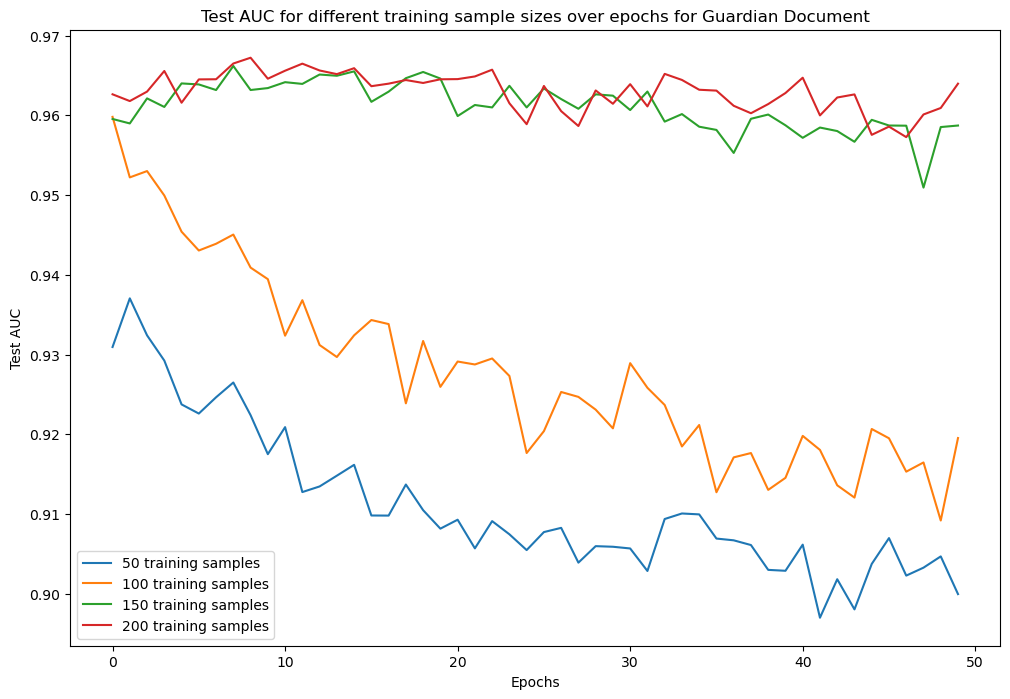

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))

# loop over each num_train_samples
for num_samples, aucs in auc_results.items():
    plt.plot(aucs, label=f"{num_samples} training samples")

plt.xlabel('Epochs')
plt.ylabel('Test AUC')
plt.legend()
plt.title('Test AUC for different training sample sizes over epochs for Guardian Document')
plt.show()


In [8]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize the model
model = HBN(d_e, h, m, n, y, dropout_prob).to(device)

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=2e-5, eps=1e-8)


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [9]:
def train(model, dataloader, optimizer, criterion, device, epoch):
    model.train()
    total_loss = 0
    for batch in tqdm(dataloader, desc=f"Epoch {epoch + 1}/{num_epochs}"):
        input_ids, attention_mask, labels = batch
        
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, labels)
        loss.backward()
#         torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        total_loss += loss.item()
        
    return total_loss / len(dataloader)

def evaluate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    correct_predictions = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(dataloader):
            input_ids, attention_mask, labels = batch

            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            labels = labels.to(device)

            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            _, preds = torch.max(outputs, dim=1)
            correct_predictions += torch.sum(preds == labels)
            
            # For AUC
            # Assuming binary classification; you need to get the probabilities for the positive class
            probs = torch.nn.functional.softmax(outputs, dim=1)[:, 1]
            all_preds.extend(probs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    accuracy = correct_predictions.double() / len(dataloader.dataset)
    auc = roc_auc_score(all_labels, all_preds)
    return total_loss / len(dataloader), accuracy, auc



In [10]:
# Actual Training Loop
train_loss_epoch = []
test_loss_epoch = []
auc = []
for epoch in range(num_epochs):
    train_loss = train(model, train_loader, optimizer, criterion, device, epoch)
    print(f"Train Loss: {train_loss:.4f}")
    val_loss, val_accuracy, val_auc = evaluate(model, val_loader, criterion, device)
    print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}, Val AUC: {val_auc:.4f}")
    train_loss_epoch.append(train_loss)
    test_loss_epoch.append(val_loss)
    auc.append(val_auc)

Epoch 1/50: 100%|█████████████████████████████████████████████████████████████████████| 242/242 [00:41<00:00,  5.81it/s]


Train Loss: 0.6490


100%|███████████████████████████████████████████████████████████████████████████████████| 47/47 [00:08<00:00,  5.77it/s]


Val Loss: 0.4804, Val Accuracy: 0.7861, Val AUC: 0.8495


Epoch 2/50: 100%|█████████████████████████████████████████████████████████████████████| 242/242 [00:37<00:00,  6.51it/s]


Train Loss: 0.4190


100%|███████████████████████████████████████████████████████████████████████████████████| 47/47 [00:08<00:00,  5.77it/s]


Val Loss: 0.5311, Val Accuracy: 0.7112, Val AUC: 0.8846


Epoch 3/50: 100%|█████████████████████████████████████████████████████████████████████| 242/242 [00:37<00:00,  6.50it/s]


Train Loss: 0.3206


100%|███████████████████████████████████████████████████████████████████████████████████| 47/47 [00:08<00:00,  5.78it/s]


Val Loss: 0.4171, Val Accuracy: 0.8182, Val AUC: 0.8994


Epoch 4/50: 100%|█████████████████████████████████████████████████████████████████████| 242/242 [00:37<00:00,  6.46it/s]


Train Loss: 0.2878


100%|███████████████████████████████████████████████████████████████████████████████████| 47/47 [00:08<00:00,  5.77it/s]


Val Loss: 0.4285, Val Accuracy: 0.8342, Val AUC: 0.9023


Epoch 5/50: 100%|█████████████████████████████████████████████████████████████████████| 242/242 [00:36<00:00,  6.54it/s]


Train Loss: 0.2532


100%|███████████████████████████████████████████████████████████████████████████████████| 47/47 [00:08<00:00,  5.78it/s]


Val Loss: 0.3964, Val Accuracy: 0.8342, Val AUC: 0.9045


Epoch 6/50: 100%|█████████████████████████████████████████████████████████████████████| 242/242 [00:37<00:00,  6.52it/s]


Train Loss: 0.2469


100%|███████████████████████████████████████████████████████████████████████████████████| 47/47 [00:08<00:00,  5.78it/s]


Val Loss: 0.5249, Val Accuracy: 0.7647, Val AUC: 0.9016


Epoch 7/50: 100%|█████████████████████████████████████████████████████████████████████| 242/242 [00:37<00:00,  6.46it/s]


Train Loss: 0.2201


100%|███████████████████████████████████████████████████████████████████████████████████| 47/47 [00:08<00:00,  5.77it/s]


Val Loss: 0.9975, Val Accuracy: 0.6631, Val AUC: 0.8982


Epoch 8/50: 100%|█████████████████████████████████████████████████████████████████████| 242/242 [00:37<00:00,  6.43it/s]


Train Loss: 0.2192


100%|███████████████████████████████████████████████████████████████████████████████████| 47/47 [00:08<00:00,  5.78it/s]


Val Loss: 0.5212, Val Accuracy: 0.7914, Val AUC: 0.9013


Epoch 9/50: 100%|█████████████████████████████████████████████████████████████████████| 242/242 [00:37<00:00,  6.49it/s]


Train Loss: 0.1940


100%|███████████████████████████████████████████████████████████████████████████████████| 47/47 [00:08<00:00,  5.74it/s]


Val Loss: 0.4572, Val Accuracy: 0.8235, Val AUC: 0.8973


Epoch 10/50: 100%|████████████████████████████████████████████████████████████████████| 242/242 [00:37<00:00,  6.51it/s]


Train Loss: 0.2088


100%|███████████████████████████████████████████████████████████████████████████████████| 47/47 [00:08<00:00,  5.82it/s]


Val Loss: 0.4622, Val Accuracy: 0.7968, Val AUC: 0.9059


Epoch 11/50: 100%|████████████████████████████████████████████████████████████████████| 242/242 [00:38<00:00,  6.33it/s]


Train Loss: 0.2133


100%|███████████████████████████████████████████████████████████████████████████████████| 47/47 [00:08<00:00,  5.61it/s]


Val Loss: 0.4067, Val Accuracy: 0.8235, Val AUC: 0.9007


Epoch 12/50: 100%|████████████████████████████████████████████████████████████████████| 242/242 [00:37<00:00,  6.37it/s]


Train Loss: 0.2002


100%|███████████████████████████████████████████████████████████████████████████████████| 47/47 [00:08<00:00,  5.66it/s]


Val Loss: 0.5279, Val Accuracy: 0.8128, Val AUC: 0.9007


Epoch 13/50: 100%|████████████████████████████████████████████████████████████████████| 242/242 [00:38<00:00,  6.31it/s]


Train Loss: 0.1756


100%|███████████████████████████████████████████████████████████████████████████████████| 47/47 [00:08<00:00,  5.58it/s]


Val Loss: 0.4412, Val Accuracy: 0.8128, Val AUC: 0.8897


Epoch 14/50: 100%|████████████████████████████████████████████████████████████████████| 242/242 [00:37<00:00,  6.46it/s]


Train Loss: 0.1747


100%|███████████████████████████████████████████████████████████████████████████████████| 47/47 [00:08<00:00,  5.75it/s]


Val Loss: 0.5341, Val Accuracy: 0.8021, Val AUC: 0.8828


Epoch 15/50: 100%|████████████████████████████████████████████████████████████████████| 242/242 [00:37<00:00,  6.44it/s]


Train Loss: 0.1666


100%|███████████████████████████████████████████████████████████████████████████████████| 47/47 [00:08<00:00,  5.79it/s]


Val Loss: 0.6501, Val Accuracy: 0.7861, Val AUC: 0.8924


Epoch 16/50: 100%|████████████████████████████████████████████████████████████████████| 242/242 [00:37<00:00,  6.39it/s]


Train Loss: 0.1561


100%|███████████████████████████████████████████████████████████████████████████████████| 47/47 [00:08<00:00,  5.75it/s]


Val Loss: 0.6508, Val Accuracy: 0.7807, Val AUC: 0.8818


Epoch 17/50: 100%|████████████████████████████████████████████████████████████████████| 242/242 [00:38<00:00,  6.34it/s]


Train Loss: 0.1765


100%|███████████████████████████████████████████████████████████████████████████████████| 47/47 [00:08<00:00,  5.76it/s]


Val Loss: 0.4626, Val Accuracy: 0.8075, Val AUC: 0.8836


Epoch 18/50: 100%|████████████████████████████████████████████████████████████████████| 242/242 [00:38<00:00,  6.34it/s]


Train Loss: 0.1361


100%|███████████████████████████████████████████████████████████████████████████████████| 47/47 [00:08<00:00,  5.72it/s]


Val Loss: 0.6676, Val Accuracy: 0.7807, Val AUC: 0.8836


Epoch 19/50: 100%|████████████████████████████████████████████████████████████████████| 242/242 [00:37<00:00,  6.45it/s]


Train Loss: 0.1428


100%|███████████████████████████████████████████████████████████████████████████████████| 47/47 [00:08<00:00,  5.77it/s]


Val Loss: 0.6833, Val Accuracy: 0.7647, Val AUC: 0.8862


Epoch 20/50: 100%|████████████████████████████████████████████████████████████████████| 242/242 [00:37<00:00,  6.43it/s]


Train Loss: 0.1618


100%|███████████████████████████████████████████████████████████████████████████████████| 47/47 [00:08<00:00,  5.73it/s]


Val Loss: 0.6700, Val Accuracy: 0.7647, Val AUC: 0.8654


Epoch 21/50: 100%|████████████████████████████████████████████████████████████████████| 242/242 [00:37<00:00,  6.50it/s]


Train Loss: 0.1625


100%|███████████████████████████████████████████████████████████████████████████████████| 47/47 [00:08<00:00,  5.78it/s]


Val Loss: 0.5069, Val Accuracy: 0.7968, Val AUC: 0.8718


Epoch 22/50: 100%|████████████████████████████████████████████████████████████████████| 242/242 [00:37<00:00,  6.49it/s]


Train Loss: 0.1506


100%|███████████████████████████████████████████████████████████████████████████████████| 47/47 [00:08<00:00,  5.76it/s]


Val Loss: 0.6967, Val Accuracy: 0.7540, Val AUC: 0.8797


Epoch 23/50: 100%|████████████████████████████████████████████████████████████████████| 242/242 [00:37<00:00,  6.45it/s]


Train Loss: 0.1372


100%|███████████████████████████████████████████████████████████████████████████████████| 47/47 [00:08<00:00,  5.78it/s]


Val Loss: 0.6831, Val Accuracy: 0.7754, Val AUC: 0.8728


Epoch 24/50: 100%|████████████████████████████████████████████████████████████████████| 242/242 [00:37<00:00,  6.43it/s]


Train Loss: 0.1368


100%|███████████████████████████████████████████████████████████████████████████████████| 47/47 [00:08<00:00,  5.79it/s]


Val Loss: 0.8222, Val Accuracy: 0.7166, Val AUC: 0.8779


Epoch 25/50: 100%|████████████████████████████████████████████████████████████████████| 242/242 [00:37<00:00,  6.51it/s]


Train Loss: 0.1669


100%|███████████████████████████████████████████████████████████████████████████████████| 47/47 [00:08<00:00,  5.79it/s]


Val Loss: 0.5356, Val Accuracy: 0.7807, Val AUC: 0.8875


Epoch 26/50: 100%|████████████████████████████████████████████████████████████████████| 242/242 [00:37<00:00,  6.46it/s]


Train Loss: 0.1257


100%|███████████████████████████████████████████████████████████████████████████████████| 47/47 [00:08<00:00,  5.77it/s]


Val Loss: 0.6753, Val Accuracy: 0.7807, Val AUC: 0.8775


Epoch 27/50: 100%|████████████████████████████████████████████████████████████████████| 242/242 [00:37<00:00,  6.50it/s]


Train Loss: 0.1409


100%|███████████████████████████████████████████████████████████████████████████████████| 47/47 [00:08<00:00,  5.76it/s]


Val Loss: 0.5834, Val Accuracy: 0.7861, Val AUC: 0.8613


Epoch 28/50: 100%|████████████████████████████████████████████████████████████████████| 242/242 [00:37<00:00,  6.49it/s]


Train Loss: 0.1307


100%|███████████████████████████████████████████████████████████████████████████████████| 47/47 [00:08<00:00,  5.78it/s]


Val Loss: 0.5700, Val Accuracy: 0.7968, Val AUC: 0.8645


Epoch 29/50: 100%|████████████████████████████████████████████████████████████████████| 242/242 [00:37<00:00,  6.50it/s]


Train Loss: 0.1341


100%|███████████████████████████████████████████████████████████████████████████████████| 47/47 [00:08<00:00,  5.65it/s]


Val Loss: 0.8030, Val Accuracy: 0.7754, Val AUC: 0.8712


Epoch 30/50: 100%|████████████████████████████████████████████████████████████████████| 242/242 [00:38<00:00,  6.34it/s]


Train Loss: 0.1197


100%|███████████████████████████████████████████████████████████████████████████████████| 47/47 [00:08<00:00,  5.80it/s]


Val Loss: 0.5701, Val Accuracy: 0.8235, Val AUC: 0.8736


Epoch 31/50: 100%|████████████████████████████████████████████████████████████████████| 242/242 [00:37<00:00,  6.49it/s]


Train Loss: 0.1335


100%|███████████████████████████████████████████████████████████████████████████████████| 47/47 [00:08<00:00,  5.68it/s]


Val Loss: 0.6508, Val Accuracy: 0.7701, Val AUC: 0.8796


Epoch 32/50: 100%|████████████████████████████████████████████████████████████████████| 242/242 [00:37<00:00,  6.48it/s]


Train Loss: 0.1198


100%|███████████████████████████████████████████████████████████████████████████████████| 47/47 [00:08<00:00,  5.80it/s]


Val Loss: 0.7147, Val Accuracy: 0.7754, Val AUC: 0.8817


Epoch 33/50: 100%|████████████████████████████████████████████████████████████████████| 242/242 [00:38<00:00,  6.35it/s]


Train Loss: 0.1256


100%|███████████████████████████████████████████████████████████████████████████████████| 47/47 [00:08<00:00,  5.76it/s]


Val Loss: 0.7873, Val Accuracy: 0.7380, Val AUC: 0.8676


Epoch 34/50: 100%|████████████████████████████████████████████████████████████████████| 242/242 [00:38<00:00,  6.21it/s]


Train Loss: 0.1393


100%|███████████████████████████████████████████████████████████████████████████████████| 47/47 [00:08<00:00,  5.66it/s]


Val Loss: 0.6016, Val Accuracy: 0.7861, Val AUC: 0.8657


Epoch 35/50: 100%|████████████████████████████████████████████████████████████████████| 242/242 [00:37<00:00,  6.39it/s]


Train Loss: 0.1428


100%|███████████████████████████████████████████████████████████████████████████████████| 47/47 [00:08<00:00,  5.81it/s]


Val Loss: 0.6292, Val Accuracy: 0.7487, Val AUC: 0.8658


Epoch 36/50: 100%|████████████████████████████████████████████████████████████████████| 242/242 [00:37<00:00,  6.43it/s]


Train Loss: 0.1058


100%|███████████████████████████████████████████████████████████████████████████████████| 47/47 [00:08<00:00,  5.80it/s]


Val Loss: 0.6518, Val Accuracy: 0.7380, Val AUC: 0.8785


Epoch 37/50: 100%|████████████████████████████████████████████████████████████████████| 242/242 [00:37<00:00,  6.51it/s]


Train Loss: 0.1137


100%|███████████████████████████████████████████████████████████████████████████████████| 47/47 [00:08<00:00,  5.80it/s]


Val Loss: 0.6094, Val Accuracy: 0.7914, Val AUC: 0.8694


Epoch 38/50: 100%|████████████████████████████████████████████████████████████████████| 242/242 [00:37<00:00,  6.50it/s]


Train Loss: 0.0932


100%|███████████████████████████████████████████████████████████████████████████████████| 47/47 [00:08<00:00,  5.77it/s]


Val Loss: 0.9268, Val Accuracy: 0.7380, Val AUC: 0.8601


Epoch 39/50: 100%|████████████████████████████████████████████████████████████████████| 242/242 [00:37<00:00,  6.50it/s]


Train Loss: 0.1058


100%|███████████████████████████████████████████████████████████████████████████████████| 47/47 [00:08<00:00,  5.80it/s]


Val Loss: 1.1133, Val Accuracy: 0.6578, Val AUC: 0.8600


Epoch 40/50: 100%|████████████████████████████████████████████████████████████████████| 242/242 [00:37<00:00,  6.46it/s]


Train Loss: 0.1220


100%|███████████████████████████████████████████████████████████████████████████████████| 47/47 [00:08<00:00,  5.78it/s]


Val Loss: 0.4746, Val Accuracy: 0.8075, Val AUC: 0.8725


Epoch 41/50: 100%|████████████████████████████████████████████████████████████████████| 242/242 [00:37<00:00,  6.46it/s]


Train Loss: 0.1040


100%|███████████████████████████████████████████████████████████████████████████████████| 47/47 [00:08<00:00,  5.79it/s]


Val Loss: 0.7674, Val Accuracy: 0.8021, Val AUC: 0.8851


Epoch 42/50: 100%|████████████████████████████████████████████████████████████████████| 242/242 [00:37<00:00,  6.39it/s]


Train Loss: 0.1214


100%|███████████████████████████████████████████████████████████████████████████████████| 47/47 [00:08<00:00,  5.79it/s]


Val Loss: 0.5276, Val Accuracy: 0.7754, Val AUC: 0.8562


Epoch 43/50: 100%|████████████████████████████████████████████████████████████████████| 242/242 [00:38<00:00,  6.31it/s]


Train Loss: 0.1160


100%|███████████████████████████████████████████████████████████████████████████████████| 47/47 [00:08<00:00,  5.80it/s]


Val Loss: 1.1208, Val Accuracy: 0.6631, Val AUC: 0.8546


Epoch 44/50: 100%|████████████████████████████████████████████████████████████████████| 242/242 [00:37<00:00,  6.45it/s]


Train Loss: 0.1053


100%|███████████████████████████████████████████████████████████████████████████████████| 47/47 [00:08<00:00,  5.73it/s]


Val Loss: 0.7332, Val Accuracy: 0.7754, Val AUC: 0.8763


Epoch 45/50: 100%|████████████████████████████████████████████████████████████████████| 242/242 [00:37<00:00,  6.38it/s]


Train Loss: 0.0807


100%|███████████████████████████████████████████████████████████████████████████████████| 47/47 [00:08<00:00,  5.75it/s]


Val Loss: 0.8049, Val Accuracy: 0.7968, Val AUC: 0.8565


Epoch 46/50: 100%|████████████████████████████████████████████████████████████████████| 242/242 [00:37<00:00,  6.37it/s]


Train Loss: 0.1203


100%|███████████████████████████████████████████████████████████████████████████████████| 47/47 [00:08<00:00,  5.78it/s]


Val Loss: 0.9681, Val Accuracy: 0.7059, Val AUC: 0.8498


Epoch 47/50: 100%|████████████████████████████████████████████████████████████████████| 242/242 [00:37<00:00,  6.45it/s]


Train Loss: 0.0986


100%|███████████████████████████████████████████████████████████████████████████████████| 47/47 [00:08<00:00,  5.74it/s]


Val Loss: 0.6880, Val Accuracy: 0.7968, Val AUC: 0.8623


Epoch 48/50: 100%|████████████████████████████████████████████████████████████████████| 242/242 [00:37<00:00,  6.45it/s]


Train Loss: 0.1099


100%|███████████████████████████████████████████████████████████████████████████████████| 47/47 [00:08<00:00,  5.79it/s]


Val Loss: 0.6529, Val Accuracy: 0.7914, Val AUC: 0.8606


Epoch 49/50: 100%|████████████████████████████████████████████████████████████████████| 242/242 [00:37<00:00,  6.41it/s]


Train Loss: 0.1100


100%|███████████████████████████████████████████████████████████████████████████████████| 47/47 [00:08<00:00,  5.73it/s]


Val Loss: 0.7239, Val Accuracy: 0.7647, Val AUC: 0.8706


Epoch 50/50: 100%|████████████████████████████████████████████████████████████████████| 242/242 [00:37<00:00,  6.45it/s]


Train Loss: 0.1050


100%|███████████████████████████████████████████████████████████████████████████████████| 47/47 [00:08<00:00,  5.75it/s]

Val Loss: 0.7306, Val Accuracy: 0.7754, Val AUC: 0.8662


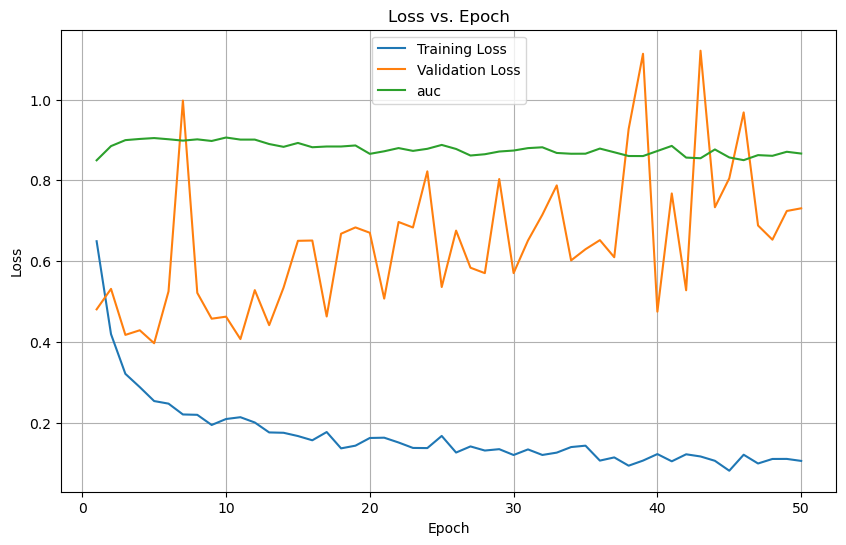

In [11]:
import matplotlib.pyplot as plt

# Plot Loss vs. Epoch
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss_epoch, label='Training Loss')
plt.plot(epochs, test_loss_epoch, label='Validation Loss')
plt.plot(epochs, auc, label='auc')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs. Epoch')
plt.legend()
plt.grid(True)
plt.show()


In [12]:
val_loss, val_accuracy, val_auc = evaluate(model, test_loader, criterion, device)
print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}, Val AUC: {val_auc:.4f}")

100%|███████████████████████████████████████████████████████████████████████████████| 2404/2404 [06:41<00:00,  5.98it/s]

Val Loss: 0.4719, Val Accuracy: 0.8644, Val AUC: 0.9362


In [13]:
len(test_loader.dataset)

9614